In [75]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision

from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import numpy as np


In [76]:
train_transform = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(0.5)
         transforms.RandomVerticalFlip(0.5)
        ,transforms.RandomRotation(24)
        # ,transforms.RandomErasing(0.4)
    #  transforms.CenterCrop(16),
    #  transforms.RandomCrop(24),
        ,transforms.ToTensor()
        ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ] 
)


In [82]:
trainset = ImageFolder("data/train/", transform=train_transform)


In [83]:
classes = []

for image in trainset.imgs:
    the_class = image[0].split("/")[2].split("\\")[0]
    if the_class not in classes:
        classes.append(the_class)

print(len(classes))
print(classes)


50
['acoustic', 'antenna', 'bacteria', 'battery', 'bean', 'beetle', 'bicycle', 'birch', 'bird', 'bomb', 'bread', 'bridge', 'camera', 'carbon', 'cat', 'corn', 'crab', 'crocodilian', 'echinoderm', 'egg', 'elephant', 'fish', 'flower', 'frog', 'fungus', 'gauge', 'hammer', 'icecream', 'kangaroo', 'memorial', 'monkey', 'motor', 'nest', 'palm', 'pizza', 'pot', 'printer', 'saw', 'snake', 'spice', 'spider', 'spoon', 'squash', 'swine', 'tea', 'tomato', 'towel', 'truck', 'turtle', 'worm']


In [84]:
from random import shuffle

all_data = list(trainset)
shuffle(all_data)

trainset = all_data


In [85]:
n = len(trainset)
n_test = int(0.25 * len(trainset))
validset = Subset(trainset, range(n_test))
trainset = Subset(trainset, range(n_test, n))

BATCH_SIZE = 32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)


In [87]:
_classes = list()

for cls in range(len(validset)):
    _classes.append(classes[validset[cls][1]])

len(set(_classes)) 

# print(classes[validset[10000][1]])
# plt.imshow(np.transpose(validset[10000][0].numpy(), (1, 2, 0)))

50

In [88]:
images, labels = next(iter(trainloader))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


towel


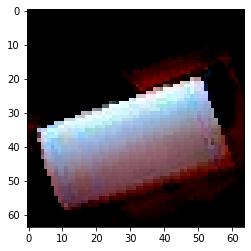

In [89]:
print(classes[labels[1]])
plt.imshow(np.transpose(images[1].numpy(), (1, 2, 0)))


In [176]:
class Net(nn.Module):
    def __init__(self, in_chanels: int, out_chanels: int, classes: int):
        super().__init__()

        ## Warstwa konwolucyjna
        self.conv1 = nn.Conv2d(
            in_channels=in_chanels,
            out_channels=out_chanels,
            kernel_size=5,
            stride=1,
            padding=0
        )

        ## Warstwa max pooling 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(out_chanels, 2*out_chanels, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(2*out_chanels, 3*out_chanels, 5)
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(384, 4*out_chanels*6)
        self.fc2 = nn.Linear(4*out_chanels * 6, 192)
        self.fc3 = nn.Linear(192, 4*out_chanels * 6)
        self.drop1 = nn.Dropout(0.7)
        self.drop2 = nn.Dropout(0.7)
        self.drop3 = nn.Dropout(0.7)
        self.fc4 = nn.Linear(4*out_chanels * 6, classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x


net = Net(3, 8, len(classes))
net


Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=384, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=192, bias=True)
  (fc3): Linear(in_features=192, out_features=192, bias=True)
  (drop1): Dropout(p=0.7, inplace=False)
  (drop2): Dropout(p=0.7, inplace=False)
  (drop3): Dropout(p=0.7, inplace=False)
  (fc4): Linear(in_features=192, out_features=50, bias=True)
)

In [177]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [178]:
epochs = 25


In [179]:
len(trainset)

66009

In [180]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        # if not (i % 200):
        #     print(f"[{i}] loss: {running_loss/200}")
        #     running_loss = 0.0


    print(f"[{epoch+1}/{epochs}] loss: {running_loss/len(trainset)}")
    running_loss = 0.0

print('Finished Training')



torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32, 192])
torch.Size

KeyboardInterrupt: 

In [109]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data    
        # images = images.to(device)
        outputs = net(images)#.cpu()   
        _, predictions = torch.max(outputs, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


total_accuracy = 0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname} is: {accuracy}")
    total_accuracy += accuracy

print('\nTotal accuracy:', total_accuracy/50)


Accuracy for class acoustic is: 11.990950226244344
Accuracy for class antenna is: 18.46846846846847
Accuracy for class bacteria is: 20.734341252699785
Accuracy for class battery is: 17.14922048997773
Accuracy for class bean is: 25.471698113207548
Accuracy for class beetle is: 42.65734265734266
Accuracy for class bicycle is: 27.897838899803535
Accuracy for class birch is: 17.8343949044586
Accuracy for class bird is: 11.991434689507495
Accuracy for class bomb is: 22.40566037735849
Accuracy for class bread is: 22.59259259259259
Accuracy for class bridge is: 20.861678004535147
Accuracy for class camera is: 27.5626423690205
Accuracy for class carbon is: 12.142857142857142
Accuracy for class cat is: 12.258064516129032
Accuracy for class corn is: 15.466101694915254
Accuracy for class crab is: 14.0
Accuracy for class crocodilian is: 15.909090909090908
Accuracy for class echinoderm is: 16.27906976744186
Accuracy for class egg is: 14.791666666666666
Accuracy for class elephant is: 17.32776617954